In [1]:
# Insert code here.
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
dtype=torch.float

%matplotlib inline


In [2]:
# for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)

In [3]:
# Define some more general functions
def dfx(x,f):
    # Calculate the derivative with auto-differention
    return grad([f], [x], grad_outputs=torch.ones(x.shape, dtype=dtype), create_graph=True)[0]

def perturbPoints(grid,t0,tf,sig=0.5):
#   stochastic perturbation of the evaluation points
#   force t[0]=t0  & force points to be in the t-interval
    delta_t = grid[1] - grid[0]  
    noise = delta_t * torch.randn_like(grid)*sig
    t = grid + noise
    t.data[2] = torch.ones(1,1)*(-1)
    t.data[t<t0]=t0 - t.data[t<t0]
    t.data[t>tf]=2*tf - t.data[t>tf]
    t.data[0] = torch.ones(1,1)*t0

    t.data[-1] = torch.ones(1,1)*tf
    t.requires_grad = False
    return t

In [4]:
def parametricSolutions(t, nn, t0, x1):
    # parametric solutions 
    N1,N2 = nn(t)
    dt =t-t0
#### THERE ARE TWO PARAMETRIC SOLUTIONS. Uncomment f=dt 
    f = (1-torch.exp(-dt))*(1-torch.exp(dt-1))
#     f=dt
    psi_hat  = x1  + f*N1
    return psi_hat


def hamEqs_Loss(t,psi, E):

    psi_dx = dfx(t,psi)
    psi_ddx= dfx(t,psi_dx)
    f = psi_ddx/2 + E*psi
    L  = (f.pow(2)).mean(); 
    return L

In [5]:
class qNN1(torch.nn.Module):
    def __init__(self, D_hid=10):
        super(qNN1,self).__init__()

        # Define the Activation
        #  self.actF = torch.nn.Sigmoid()   
        self.actF = mySin()
        
        # define layers
        #self.Lin_1   = torch.nn.Linear(1, D_hid)
        #self.E_out = torch.nn.Linear(D_hid, 1)
        #self.Lin_2 = torch.nn.Linear(D_hid, D_hid)
        #self.Ein = torch.nn.Linear(1,1)
        #self.Lin_out = torch.nn.Linear(D_hid+1, 1)
        
        self.Ein    = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(2, D_hid)
        self.Lin_2  = torch.nn.Linear(D_hid, D_hid)
        self.out    = torch.nn.Linear(D_hid, 1)

    def forward(self,t):
        In1 = self.Ein(torch.ones_like(t))
        L1 = self.Lin_1(torch.cat((t,In1),1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        out = self.out(h2)
        return out, In1

In [6]:
# Train the NN
def run_Scan_finitewell(t0, tf, x1, neurons, epochs, n_train,lr, minibatch_number = 1):
    fc0 = qNN1(neurons)
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = [];     Llim =  1e+20
    En_loss_history = []
    boundary_loss_history = []
    nontriv_loss_history = []
    SE_loss_history = []
    Ennontriv_loss_history = []
    criteria_loss_history = []
    En_history = []
    EWall_history = []
    di = (None, 1e+20)
    dic = {0:di, 1:di, 2:di, 3:di, 4:di, 5:di, 6:di, 7:di, 8:di, 9:di, 10:di}
    
    grid = torch.linspace(t0, tf, n_train).reshape(-1,1)
    
    ## TRAINING ITERATION    
    TeP0 = time.time()
    walle = -4
    last_psi_L = 0
    for tt in range(epochs): 
        #adjusting learning rate at epoch 3e4
        #if tt == 3e4:
        #    optimizer = optim.Adam(fc0.parameters(), lr = 1e-2, betas = betas)
# Perturbing the evaluation points & forcing t[0]=t0
        t=perturbPoints(grid,t0,tf,sig=.03*tf)
            
# BATCHING
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        t_b = t[idx]
        t_b.requires_grad = True
        t_f=t[-1]
        t_f=t_f.reshape(-1,1)
        t_f.requires_grad = True
        loss=0.0


        for nbatch in range(minibatch_number): 
# batch time set
            t_mb = t_b[batch_start:batch_end]

#  Network solutions 
            nn, En = fc0(t_mb)

            En_history.append(En[0].data.tolist()[0])

            psi  = parametricSolutions(t_mb, fc0, t0, x1) 
            Ltot = hamEqs_Loss(t_mb, psi, En)
            SE_loss_history.append(Ltot) #
            
            #psi_f  = parametricSolutions(t_f, fc0, t0, x1)
            
            criteria_loss = Ltot #(psi_f.pow(2)).mean() +

            if tt%2500 == 0:
              walle += 1
            Ltot += 1/((psi.pow(2)).mean()+1e-6) + 1/(En.pow(2).mean()+1e-6) + torch.exp(-1*En+walle).mean() #(psi_f.pow(2)).mean()+
            En_loss_history.append(torch.exp(-1*En+walle).mean()) #
            EWall_history.append(walle)

            
            
            #boundary_loss_history.append((psi_f.pow(2)).mean()) # 
            nontriv_loss_history.append(1/((psi.pow(2)).mean()+1e-6)) #
            Ennontriv_loss_history.append(1/(En.pow(2).mean()+1e-6)) #
            criteria_loss_history.append(criteria_loss)
# OPTIMIZER
            Ltot.backward(retain_graph=False); #True
            optimizer.step(); loss += Ltot.data.numpy()
            optimizer.zero_grad()

            batch_start +=batch_size
            batch_end +=batch_size

# keep the loss function history
        Loss_history.append(loss)       

#Keep the best model (lowest loss) by using a deep copy
        if  criteria_loss < Llim:
            fc1 =  copy.deepcopy(fc0)
            Llim=criteria_loss

        E_bin = abs(En[0].data.tolist()[0]//10) 
        if criteria_loss < dic[E_bin][1]:
          dic[E_bin] = (copy.deepcopy(fc0), criteria_loss)

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history, criteria_loss_history, fc0, En_history, EWall_history, dic)
    return fc1, loss_histories, runTime

In [7]:
## Train the model 

t0 = 0.
tf = 1.
xBC1=0.

n_train, neurons, epochs, lr,mb = 100, 50, int(125e3), 8e-3, 1 
model1,loss_hists1,runTime1 = run_Scan_finitewell(t0, tf, xBC1, neurons, epochs, n_train, lr, mb)

In [9]:
import pickle

In [11]:
pickle.dump((model1,loss_hists1,runTime1),open(imgdir+'inf_plot_data.sav','wb'))

In [ ]:
aarg = np.argmin(loss_hists1[6])

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')
imgdir = '/content/gdrive/My Drive/Harvard IACS Research/Plotting Data/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Training time (minutes): 7.715102239449819


Text(0.5, 6.300000000000001, 'Epochs')

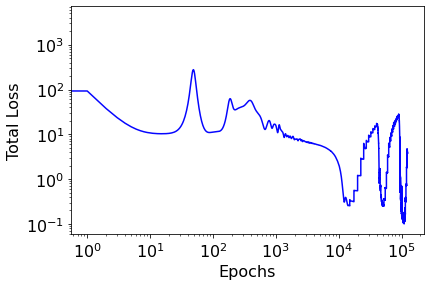

In [8]:
# Loss function
print('Training time (minutes):', runTime1/60)
plt.loglog(loss_hists1[0],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Total Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'infinite_total_loss.png', bbox_inches = 'tight')

In [12]:
# TEST THE PREDICTED SOLUTIONS
nTest = n_train; tTest = torch.linspace(t0-.1,tf+.1,nTest)
tTest = tTest.reshape(-1,1);
tTest.requires_grad=True
t_net = tTest.detach().numpy()
psi =parametricSolutions(tTest,model1,t0,xBC1) 
psi=psi.data.numpy(); 

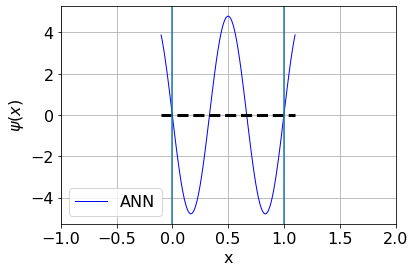

In [13]:
tru = np.sin(3*np.pi*t_net)*np.max(-1*psi)
#plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')
plt.xlim(-1,2)
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.axvline(x = 0)
plt.axvline(x = 1)


tensor(44.4136, grad_fn=<SelectBackward>)

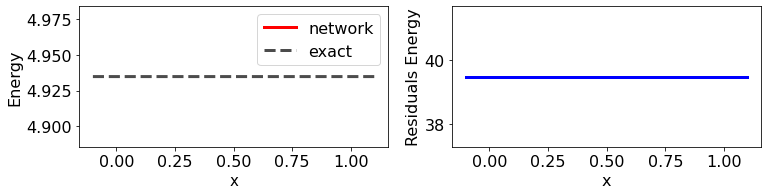

In [14]:
E1 = np.pi**2/2 # ground
p,e=model1(tTest)
#ed = dfx(tTest,e)

plt.figure(figsize=[16,3])
### 
plt.subplot(1,3,1)
plt.plot(t_net, e.data.numpy(), '-r', label='network', linewidth=3)
plt.plot(t_net, E1*t_net/t_net, '--k', label='exact', linewidth=3, alpha=0.7)
plt.ylim([0.99*E1, 1.01*E1])

plt.legend()
plt.xlabel('x',fontsize=15)
plt.ylabel('Energy')
###

plt.subplot(1,3,2)
plt.plot(t_net, e.data.numpy()-E1*t_net/t_net, '-b', linewidth=3)
# plt.ylim([-1e-3, 1e-3])
plt.xlabel('x')
plt.ylabel('Residuals Energy')

#plt.subplot(1,3,3)
#plt.plot(t_net, ed.data.numpy(),'b', linewidth=3)
#plt.xlabel('x')
#plt.ylabel('d/dx Energy')

plt.tight_layout()
e[0][0]

Text(0.5, 6.300000000000001, 't')

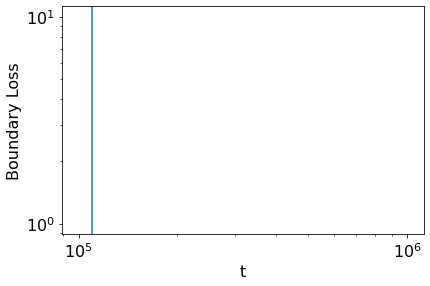

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[1],'-b',alpha=0.975);
plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Boundary Loss');plt.xlabel('t')

Text(0.5, 6.300000000000001, 'Epochs')

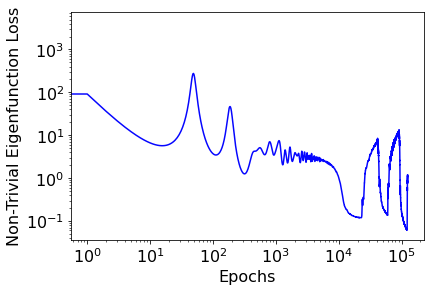

In [15]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[2],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Non-Trivial Eigenfunction Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'infinite_nontrivfunc_loss.png', bbox_inches = 'tight')

Text(0.5, 6.300000000000001, 'Epochs')

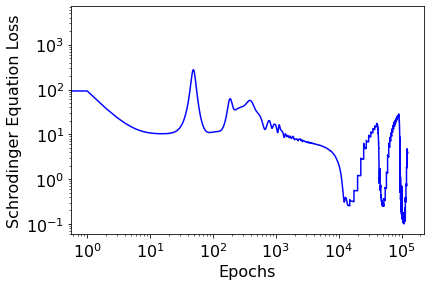

In [16]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[3],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Schrodinger Equation Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'infinite_SE_loss.png', bbox_inches = 'tight')

Text(0.5, 6.300000000000001, 'Epochs')

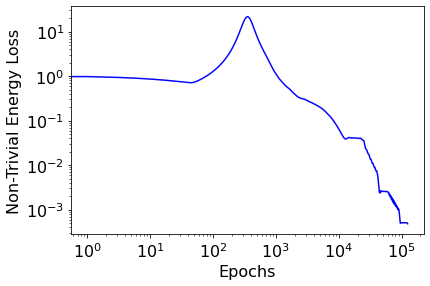

In [17]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[4],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Non-Trivial Energy Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'infinite_nontrivE_loss.png', bbox_inches = 'tight')

Text(0.5, 6.300000000000001, 'Epochs')

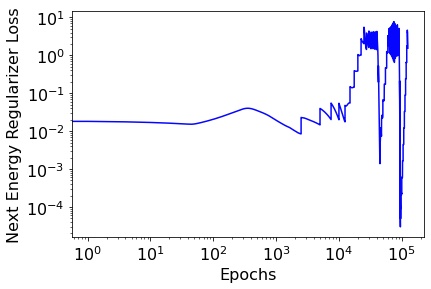

In [18]:
##(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[5],'-b',alpha=0.975);
#plt.axvline(x = aarg)

plt.tight_layout()
plt.ylabel('Next Energy Regularizer Loss');plt.xlabel('Epochs')
#plt.savefig(imgdir+'infinite_nextE_loss.png', bbox_inches = 'tight')

Text(0.5, 6.300000000000001, 'Epochs')

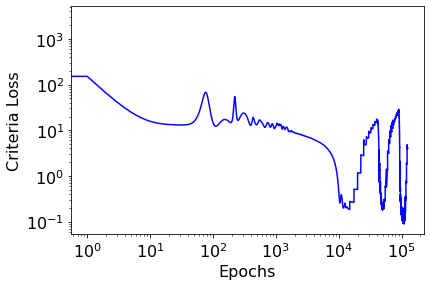

In [ ]:
#(Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history)
plt.loglog(loss_hists1[6],'-b',alpha=0.975);
#plt.axvline(x = np.argmin(loss_hists1[6]))
plt.tight_layout()
plt.ylabel('Criteria Loss');plt.xlabel('Epochs')

# In this case, criteria loss is same as SE Loss

Text(0.5, 0, 'Epochs')

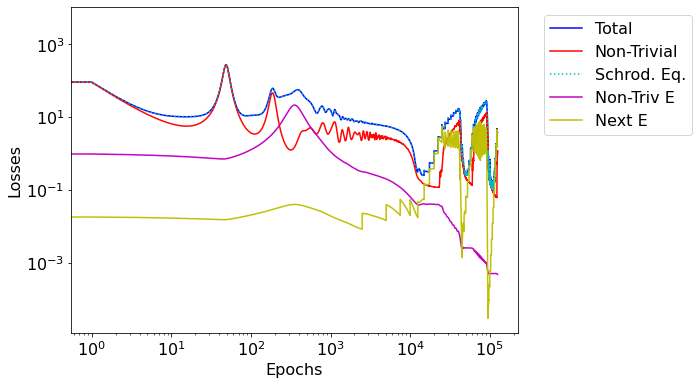

In [19]:
# Loss_history, boundary_loss_history, nontriv_loss_history, SE_loss_history, Ennontriv_loss_history, En_loss_history
plt.figure(figsize = (8,6))
plt.loglog(loss_hists1[0],'-b',alpha=0.975, label = 'Total');
#plt.loglog(loss_hists1[1],'-g',alpha=0.975, label = 'Boundary');
plt.loglog(loss_hists1[2],'-r',alpha=0.975, label = 'Non-Trivial');
plt.loglog(loss_hists1[3],':c',alpha=0.975, label = 'Schrod. Eq.');
plt.loglog(loss_hists1[4],'-m',alpha=0.975, label = 'Non-Triv E');
plt.loglog(loss_hists1[5],'-y',alpha=0.975, label = 'Next E');
#plt.loglog(loss_hists1[6],'-k',alpha=0.975, label = 'Criteria');
#plt.axvline(x = aarg)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Losses');plt.xlabel('Epochs')
#plt.savefig(imgdir+'infinite_all_loss.png', bbox_inches = 'tight')

Text(0.5, 28.0, 'Thousand Epochs')

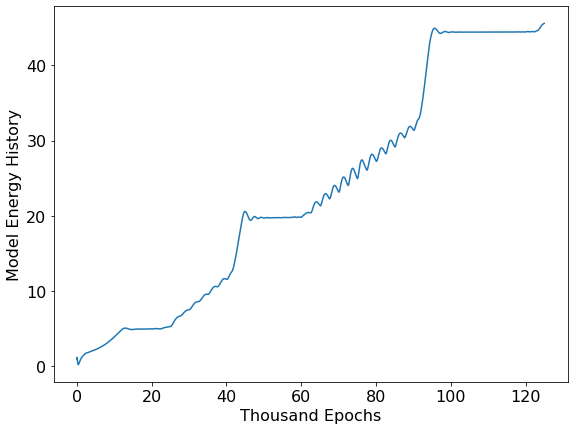

In [20]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(loss_hists1[8]))/1000, loss_hists1[8])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Model Energy History');plt.xlabel('Thousand Epochs')
#plt.savefig(imgdir+'infinite_modelE_hist.png', bbox_inches = 'tight')

Text(0.5, 28.0, 'Thousand Epochs')

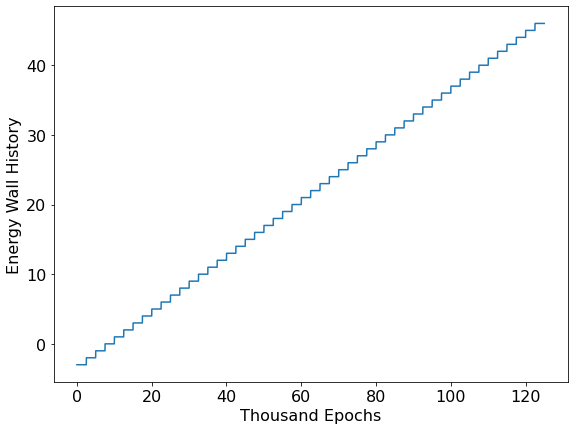

In [23]:
plt.figure(figsize = (8,6))
plt.plot(np.arange(len(loss_hists1[9]))/1000, loss_hists1[9])
#plt.axvline(x = aarg)
plt.tight_layout()
plt.ylabel('Energy Wall History');plt.xlabel('Thousand Epochs')
#plt.savefig(imgdir+'infinite_Ewall_hist.png', bbox_inches = 'tight')

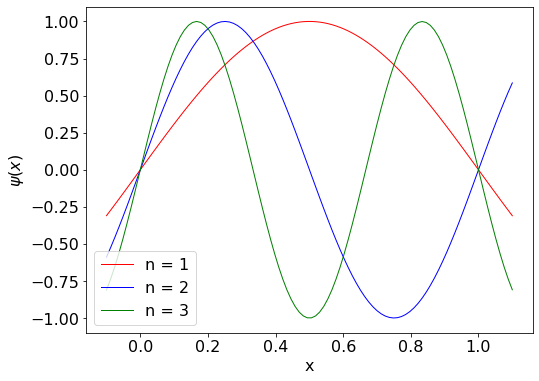

In [ ]:
plt.figure(figsize = (8,6))
psi_0to10 = parametricSolutions(tTest,loss_hists1[10][0][0],t0,xBC1)
psi_10to20 = parametricSolutions(tTest,loss_hists1[10][1][0],t0,xBC1)
#psi_20to30 = parametricSolutions(tTest,loss_hists1[10][2][0],t0,xBC1)
#psi_30to40 = parametricSolutions(tTest,loss_hists1[10][3][0],t0,xBC1)
psi_40to50 = parametricSolutions(tTest,loss_hists1[10][4][0],t0,xBC1)
#psi_50to60 = parametricSolutions(tTest,loss_hists1[10][5][0],t0,xBC1)
#psi_60to70 = parametricSolutions(tTest,loss_hists1[10][6][0],t0,xBC1)
#psi_70to80 = parametricSolutions(tTest,loss_hists1[10][7][0],t0,xBC1)

plt.plot(t_net, -1*psi_0to10.data.numpy()/np.max(np.abs(psi_0to10.data.numpy())), '-r', linewidth=1, label = 'n = 1')
plt.plot(t_net, -1*psi_10to20.data.numpy()/np.max(np.abs(psi_10to20.data.numpy())), '-b', linewidth=1, label = 'n = 2')
#plt.plot(t_net, 1*psi_20to30.data.numpy(), '-b', linewidth=1, label = 'ANN')
#plt.plot(t_net, 1*psi_30to40.data.numpy(), '-b', linewidth=1, label = 'ANN')
plt.plot(t_net, 1*psi_40to50.data.numpy()/np.max(np.abs(psi_40to50.data.numpy())), '-g', linewidth=1, label = 'n = 3')
#plt.plot(t_net, 1*psi_50to60.data.numpy(), '-b', linewidth=1, label = 'ANN')
#plt.plot(t_net, 1*psi_60to70.data.numpy(), '-b', linewidth=1, label = 'ANN')
#plt.plot(t_net, 1*psi_70to80.data.numpy(), '-b', linewidth=1, label = 'ANN')
plt.ylabel('$\psi(x)$');plt.xlabel('x')
plt.legend()
plt.savefig(imgdir+'infinite_eigenfuncs_loss.png', bbox_inches = 'tight')

In [ ]:
print(loss_hists1[10][0][0].forward(tTest)[1][0])
print(loss_hists1[10][1][0].forward(tTest)[1][0])
#print(loss_hists1[10][2][0].forward(tTest)[1][2])
#print(loss_hists1[10][3][0].forward(tTest)[1][4])
print(loss_hists1[10][4][0].forward(tTest)[1][4])
#print(loss_hists1[10][5][0].forward(tTest)[1][4])
#print(loss_hists1[10][6][0].forward(tTest)[1][4])
#print(loss_hists1[10][7][0].forward(tTest)[1][4])
#print(loss_hists1[10][8][0].forward(tTest)[1][4])


tensor([4.9251], grad_fn=<SelectBackward>)
tensor([19.7383], grad_fn=<SelectBackward>)
tensor([44.4136], grad_fn=<SelectBackward>)


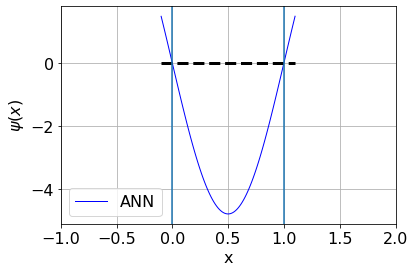

In [ ]:
psi =parametricSolutions(tTest,loss_hists1[10][0][0],t0,xBC1) 
psi=psi.data.numpy(); 

plt.xlim(-1,2)
plt.plot(t_net, 1*psi, '-b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.axvline(x = 0)
plt.axvline(x = 1)

# Error Analysis

<Figure size 432x288 with 0 Axes>

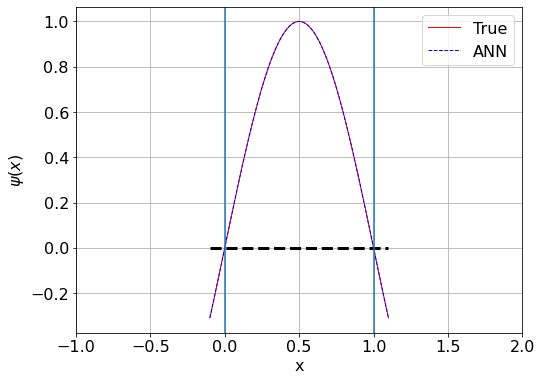

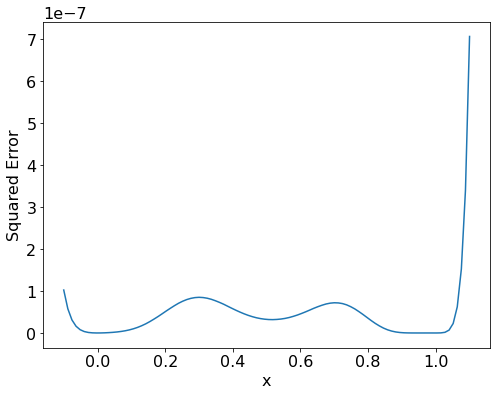

In [ ]:
# Ground state error analysis

plt.tight_layout()
plt.figure(figsize = (8,6))

psi =parametricSolutions(tTest,loss_hists1[10][0][0],t0,xBC1)
psi=psi.data.numpy(); 
psi = -1*psi/np.max(np.abs(psi))
tru = np.sin(np.pi*t_net)
plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')

plt.xlim(-1,2)
plt.plot(t_net, psi, '--b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.axvline(x = 0)
plt.axvline(x = 1)
plt.savefig(imgdir+'infinite_ground.png', bbox_inches = 'tight')

plt.figure(figsize = (8,6))
squared_error = (psi-tru)**2
plt.plot(t_net, squared_error)
plt.ylabel('Squared Error'); plt.xlabel('x')
plt.savefig(imgdir+'infinite_ground_err.png', bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

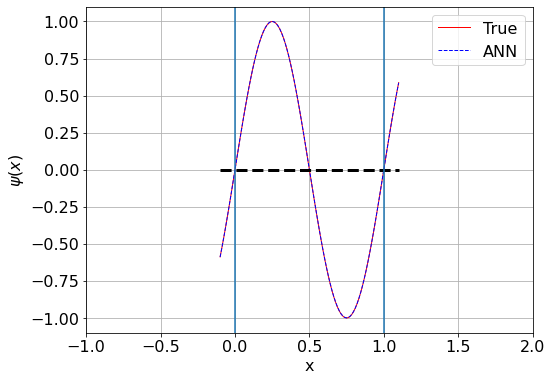

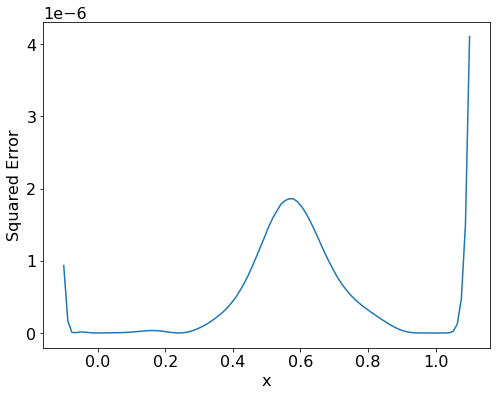

In [ ]:
# First excited state error analysis

plt.tight_layout()
plt.figure(figsize = (8,6))

psi =parametricSolutions(tTest,loss_hists1[10][1][0],t0,xBC1)
psi=psi.data.numpy(); 
psi = -1*psi/np.max(np.abs(psi))
tru = np.sin(2*np.pi*t_net)
plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')

plt.xlim(-1,2)
plt.plot(t_net, psi, '--b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.axvline(x = 0)
plt.axvline(x = 1)
plt.savefig(imgdir+'infinite_first.png', bbox_inches = 'tight')

plt.figure(figsize = (8,6))
squared_error = (psi-tru)**2
plt.plot(t_net, squared_error)
plt.ylabel('Squared Error'); plt.xlabel('x')
plt.savefig(imgdir+'infinite_first_err.png', bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

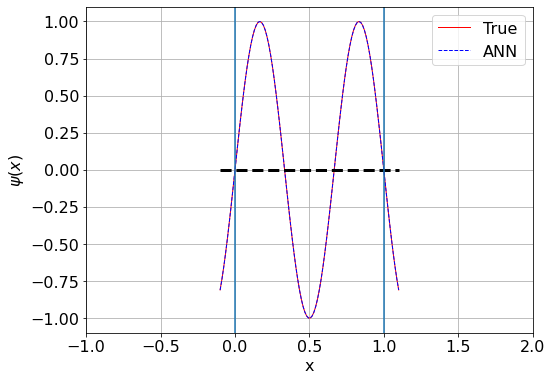

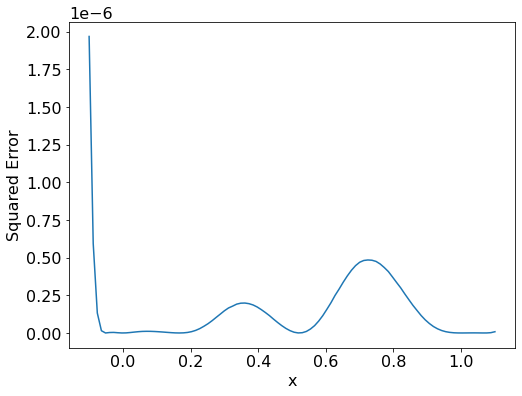

In [ ]:
# Second excited state error analysis

plt.tight_layout()
plt.figure(figsize = (8,6))

psi =parametricSolutions(tTest,loss_hists1[10][4][0],t0,xBC1)
psi=psi.data.numpy(); 
psi = 1*psi/np.max(np.abs(psi))
tru = np.sin(3*np.pi*t_net)
plt.plot(t_net, tru, '-r', linewidth = 1, label = 'True')

plt.xlim(-1,2)
plt.plot(t_net, psi, '--b', linewidth=1, label = 'ANN')
plt.legend()
plt.plot(t_net, np.zeros(len(t_net)),'--k', linewidth=3)
plt.xlabel('x')
plt.ylabel('$\psi(x)$')
plt.grid('on')
plt.axvline(x = 0)
plt.axvline(x = 1)
plt.savefig(imgdir+'infinite_second.png', bbox_inches = 'tight')

plt.figure(figsize = (8,6))
squared_error = (psi-tru)**2
plt.plot(t_net, squared_error)
plt.ylabel('Squared Error'); plt.xlabel('x')
plt.savefig(imgdir+'infinite_second_err.png', bbox_inches = 'tight')